# Railway Fault Detection
## [Dataset](https://www.kaggle.com/salmaneunus/railway-track-fault-detection)

In [1]:
train_dir = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Train'
val_dir   = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation'
test_dir  = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Test'

In [2]:
import os
train_defective_fnames = os.listdir(train_dir+'/Defective' )
train_nondefective_fnames = os.listdir(train_dir+'/Non defective')

## Show Dataset Images

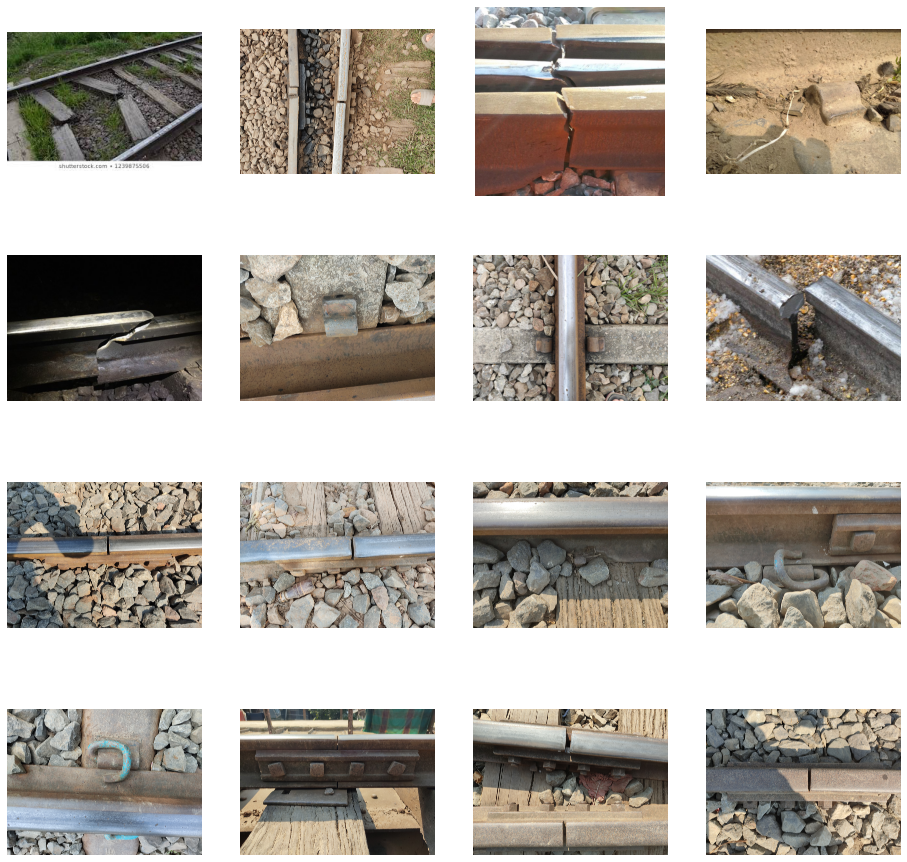

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 10x10 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_defective_pix = [os.path.join(train_dir+'/Defective', fname) 
                for fname in train_defective_fnames[pic_index-8:pic_index]]
next_nondefective_pix = [os.path.join(train_dir+'/Non defective', fname) 
                for fname in train_nondefective_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_defective_pix+next_nondefective_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Data Augmentation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_size=(300,300)
batch_size = 16

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

Found 299 images belonging to 2 classes.


In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 62 images belonging to 2 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,     
    class_mode=None)

Found 22 images belonging to 2 classes.


## Build Model

In [8]:
num_classes = 2
input_shape = (300,300,3)

In [9]:
# Build Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import models, layers

base_model=ResNet50V2(input_shape=input_shape,weights='imagenet',include_top=False) 
base_model.trainable = False # freeze the base model (for transfer learning)

# add Fully-Connected Layers to Model
x=base_model.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(128,activation='relu')(x)  # FC layer 
preds=layers.Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

model=models.Model(inputs=base_model.input,outputs=preds)
model.summary()

94674944/94668760 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
_____________________________

In [10]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [11]:
## set Checkpoint : save best only, verbose on
#checkpoint = callbacks.ModelCheckpoint("railtrack_resnet50v2.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1)

## Train Model

In [43]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL  =val_generator.n//val_generator.batch_size
STEP_SIZE_TEST =test_generator.n//test_generator.batch_size
num_epochs = 30

In [44]:
# Train Model
history = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,epochs=num_epochs, validation_data=val_generator, validation_steps=STEP_SIZE_VAL) #, callbacks=[checkpoint])

Epoch 1/30
18/18 [==============================] - 81s 5s/step - loss: 0.3918 - accuracy: 0.8233 - val_loss: 0.2616 - val_accuracy: 0.8958
Epoch 2/30
18/18 [==============================] - 78s 4s/step - loss: 0.4234 - accuracy: 0.7915 - val_loss: 0.2367 - val_accuracy: 0.9583
Epoch 3/30
18/18 [==============================] - 78s 4s/step - loss: 0.3401 - accuracy: 0.8375 - val_loss: 0.3638 - val_accuracy: 0.8125
Epoch 4/30
18/18 [==============================] - 77s 4s/step - loss: 0.3353 - accuracy: 0.8551 - val_loss: 0.2779 - val_accuracy: 0.8125
Epoch 5/30
18/18 [==============================] - 78s 4s/step - loss: 0.3158 - accuracy: 0.8587 - val_loss: 0.3086 - val_accuracy: 0.8750
Epoch 6/30
18/18 [==============================] - 76s 4s/step - loss: 0.3019 - accuracy: 0.8551 - val_loss: 0.2739 - val_accuracy: 0.8542
Epoch 7/30
18/18 [==============================] - 78s 4s/step - loss: 0.2752 - accuracy: 0.8905 - val_loss: 0.2659 - val_accuracy: 0.8750
Epoch 8/30
18/18 [==

## Save Model

In [45]:
## Save Model
models.save_model(model, 'railway_track_resnet50v2.h5')

In [46]:
## load best model weights if using callback (save-best-only)
#model.load_weights("railtrack_resnet50v2.hdf5")

## Evaluate Model

In [47]:
score = model.evaluate(test_generator, steps=STEP_SIZE_TEST) # with test dataset
print(score)

1/1 [==============================] - 3s 3s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]


## Confusion Matrix

In [48]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

predY=model.predict(test_generator) # with validation dataset
y_pred = np.argmax(predY,axis=1)
y_actual = test_generator.classes
cm = confusion_matrix(y_actual, y_pred)
print(cm)

[[7 4]
 [2 9]]


In [49]:
# report confusion matrix
labels = ['Defective', 'Non Defective']
print(classification_report(y_actual, y_pred, target_names=labels))

               precision    recall  f1-score   support

    Defective       0.78      0.64      0.70        11
Non Defective       0.69      0.82      0.75        11

     accuracy                           0.73        22
    macro avg       0.74      0.73      0.73        22
 weighted avg       0.74      0.73      0.73        22



## Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


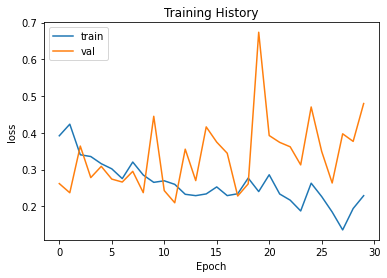

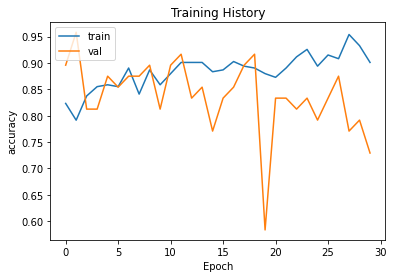

In [50]:
# Show Train History
keys=history.history.keys()
print(keys)

def show_train_history(hisData,train,val): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[val])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')

[[1. 0.]]


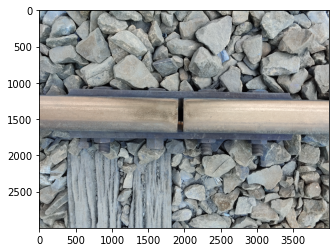

In [55]:
import cv2
import numpy as np
img = cv2.imread("../input/railway-track-fault-detection/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_100344.jpg")
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
# if classes<0.5 : non=defective
# else defective